In [66]:
import sys
sys.path.append('..')
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

In [67]:
from common.trainer import Trainer
from common.optimizer import SGD
from common.util import preprocess, create_contexts_target, convert_one_hot
from common.layers import MatMul, SoftmaxWithLoss

In [88]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        W_in = tf.Variable(tf.random.normal((V, H), mean=0.0, stddev=0.01, dtype='float'))
        W_out = tf.Variable(tf.random.normal((H, V), mean=0.0, stddev=0.01, dtype='float'))

        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        layers = [
                self.in_layer0,
                self.in_layer1,
                self.out_layer,
                self.loss_layer
        ]

        self.params = []
        self.grads = []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        
        self.grads = []
        layers = [
                self.in_layer0,
                self.in_layer1,
                self.out_layer,
                self.loss_layer
        ]
        
        for layer in layers:
            self.grads += layer.grads
        
        return None

In [89]:

def remove_duplicate(params, grads):
    '''
    パラメータ配列中の重複する重みをひとつに集約し、
    その重みに対応する勾配を加算する
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 重みを共有する場合
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 勾配の加算
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 転置行列として重みを共有する場合（weight tying）
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads


In [90]:
class Trainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.loss_list = []
        self.eval_interval = None
        self.current_epoch = 0

    def fit(self, x, t, max_epoch=10, batch_size=32, max_grad=None, eval_interval=20):
        data_size = len(x)
        max_iters = data_size // batch_size
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            # シャッフル
            idx = tf.random.shuffle(tf.range(data_size))
            x = x[idx.numpy()]
            t = t[idx.numpy()]

            for iters in range(max_iters):
                batch_x = x[iters*batch_size:(iters+1)*batch_size]
                batch_t = t[iters*batch_size:(iters+1)*batch_size]

                # 勾配を求め、パラメータを更新
                loss = model.forward(batch_x, batch_t)
                model.backward()
#                 params, grads = remove_duplicate(model.params, model.grads)  # 共有された重みを1つに集約
#                 if max_grad is not None:
#                     clip_grads(grads, max_grad)
                optimizer.update(model.params, model.grads)
                total_loss += loss
                loss_count += 1
                # 評価
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    avg_loss = total_loss / loss_count
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | loss %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, avg_loss))
                    self.loss_list.append(float(avg_loss))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = np.arange(len(self.loss_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.loss_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('loss')
        plt.show()



In [91]:
class Adam:
    '''
    Adam (http://arxiv.org/abs/1412.6980v8)
    '''
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = [], []
            for param in params:
                self.m.append(tf.Variable(tf.zeros_like(param)))
                self.v.append(tf.Variable(tf.zeros_like(param)))
        
        self.iter += 1
        lr_t = self.lr * tf.math.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for i in range(len(params)):
            self.m[i].assign(self.m[i] + (1 - self.beta1) * (grads[i] - self.m[i]))
            self.v[i].assign(self.v[i] + (1 - self.beta2) * (grads[i]**2 - self.v[i]))
            
            params[i].assign(params[i] - lr_t * self.m[i] / (tf.math.sqrt(self.v[i]) + 1e-7))

In [111]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'you say goodbye and i say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [112]:
trainer.fit(contexts, target, max_epoch, batch_size)


| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 177 |  iter 1 / 2 | time 1[s] | loss 1.22
| epoch 178 |  iter 1 / 2 | time 1[s] | loss 1.18
| epoch 179 |  iter 1 / 2 | time 1[s] | loss 1.24
| epoch 180 |  iter 1 / 2 | time 1[s] | loss 1.27
| epoch 181 |  iter 1 / 2 | time 1[s] | loss 1.12
| epoch 182 |  iter 1 / 2 | time 1[s] | loss 1.26
| epoch 183 |  iter 1 / 2 | time 1[s] | loss 1.11
| epoch 184 |  iter 1 / 2 | time 1[s] | loss 1.21
| epoch 185 |  iter 1 / 2 | time 1[s] | loss 1.15
| epoch 186 |  iter 1 / 2 | time 1[s] | loss 1.16
| epoch 187 |  iter 1 / 2 | time 1[s] | loss 1.14
| epoch 188 |  iter 1 / 2 | time 1[s] | loss 1.19
| epoch 189 |  iter 1 / 2 | time 1[s] | loss 1.16
| epoch 190 |  iter 1 / 2 | time 1[s] | loss 1.17
| epoch 191 |  iter 1 / 2 | time 1[s] | loss 1.21
| epoch 192 |  iter 1 / 2 | time 1[s] | loss 1.18
| epoch 193 |  iter 1 / 2 | time 1[s] | loss 1.04
| epoch 194 |  iter 1 / 2 | time 1[s] | loss 1.20
| epoch 195 |  iter 1 / 2 | time 1[s] | loss 1.07
| epoch 196 |  iter 1 / 2 | time 1[s] | loss 1.19


| epoch 345 |  iter 1 / 2 | time 2[s] | loss 0.75
| epoch 346 |  iter 1 / 2 | time 2[s] | loss 0.69
| epoch 347 |  iter 1 / 2 | time 2[s] | loss 0.83
| epoch 348 |  iter 1 / 2 | time 2[s] | loss 0.76
| epoch 349 |  iter 1 / 2 | time 2[s] | loss 0.74
| epoch 350 |  iter 1 / 2 | time 2[s] | loss 0.77
| epoch 351 |  iter 1 / 2 | time 2[s] | loss 0.75
| epoch 352 |  iter 1 / 2 | time 2[s] | loss 0.74
| epoch 353 |  iter 1 / 2 | time 2[s] | loss 0.75
| epoch 354 |  iter 1 / 2 | time 2[s] | loss 0.82
| epoch 355 |  iter 1 / 2 | time 2[s] | loss 0.74
| epoch 356 |  iter 1 / 2 | time 2[s] | loss 0.61
| epoch 357 |  iter 1 / 2 | time 2[s] | loss 0.81
| epoch 358 |  iter 1 / 2 | time 2[s] | loss 0.66
| epoch 359 |  iter 1 / 2 | time 2[s] | loss 0.74
| epoch 360 |  iter 1 / 2 | time 2[s] | loss 0.87
| epoch 361 |  iter 1 / 2 | time 2[s] | loss 0.67
| epoch 362 |  iter 1 / 2 | time 2[s] | loss 0.72
| epoch 363 |  iter 1 / 2 | time 2[s] | loss 0.73
| epoch 364 |  iter 1 / 2 | time 2[s] | loss 0.74


| epoch 518 |  iter 1 / 2 | time 3[s] | loss 0.48
| epoch 519 |  iter 1 / 2 | time 3[s] | loss 0.53
| epoch 520 |  iter 1 / 2 | time 3[s] | loss 0.53
| epoch 521 |  iter 1 / 2 | time 3[s] | loss 0.52
| epoch 522 |  iter 1 / 2 | time 3[s] | loss 0.55
| epoch 523 |  iter 1 / 2 | time 3[s] | loss 0.59
| epoch 524 |  iter 1 / 2 | time 3[s] | loss 0.53
| epoch 525 |  iter 1 / 2 | time 3[s] | loss 0.47
| epoch 526 |  iter 1 / 2 | time 3[s] | loss 0.58
| epoch 527 |  iter 1 / 2 | time 3[s] | loss 0.39
| epoch 528 |  iter 1 / 2 | time 3[s] | loss 0.68
| epoch 529 |  iter 1 / 2 | time 3[s] | loss 0.45
| epoch 530 |  iter 1 / 2 | time 3[s] | loss 0.51
| epoch 531 |  iter 1 / 2 | time 3[s] | loss 0.54
| epoch 532 |  iter 1 / 2 | time 3[s] | loss 0.52
| epoch 533 |  iter 1 / 2 | time 3[s] | loss 0.50
| epoch 534 |  iter 1 / 2 | time 3[s] | loss 0.62
| epoch 535 |  iter 1 / 2 | time 3[s] | loss 0.44
| epoch 536 |  iter 1 / 2 | time 3[s] | loss 0.52
| epoch 537 |  iter 1 / 2 | time 3[s] | loss 0.50


| epoch 696 |  iter 1 / 2 | time 4[s] | loss 0.38
| epoch 697 |  iter 1 / 2 | time 4[s] | loss 0.41
| epoch 698 |  iter 1 / 2 | time 4[s] | loss 0.50
| epoch 699 |  iter 1 / 2 | time 4[s] | loss 0.41
| epoch 700 |  iter 1 / 2 | time 4[s] | loss 0.36
| epoch 701 |  iter 1 / 2 | time 4[s] | loss 0.45
| epoch 702 |  iter 1 / 2 | time 4[s] | loss 0.37
| epoch 703 |  iter 1 / 2 | time 4[s] | loss 0.36
| epoch 704 |  iter 1 / 2 | time 4[s] | loss 0.45
| epoch 705 |  iter 1 / 2 | time 4[s] | loss 0.41
| epoch 706 |  iter 1 / 2 | time 4[s] | loss 0.37
| epoch 707 |  iter 1 / 2 | time 4[s] | loss 0.48
| epoch 708 |  iter 1 / 2 | time 4[s] | loss 0.42
| epoch 709 |  iter 1 / 2 | time 4[s] | loss 0.30
| epoch 710 |  iter 1 / 2 | time 4[s] | loss 0.36
| epoch 711 |  iter 1 / 2 | time 4[s] | loss 0.49
| epoch 712 |  iter 1 / 2 | time 4[s] | loss 0.45
| epoch 713 |  iter 1 / 2 | time 4[s] | loss 0.31
| epoch 714 |  iter 1 / 2 | time 4[s] | loss 0.40
| epoch 715 |  iter 1 / 2 | time 4[s] | loss 0.36


| epoch 872 |  iter 1 / 2 | time 5[s] | loss 0.42
| epoch 873 |  iter 1 / 2 | time 5[s] | loss 0.15
| epoch 874 |  iter 1 / 2 | time 5[s] | loss 0.43
| epoch 875 |  iter 1 / 2 | time 5[s] | loss 0.43
| epoch 876 |  iter 1 / 2 | time 5[s] | loss 0.15
| epoch 877 |  iter 1 / 2 | time 5[s] | loss 0.36
| epoch 878 |  iter 1 / 2 | time 5[s] | loss 0.43
| epoch 879 |  iter 1 / 2 | time 5[s] | loss 0.43
| epoch 880 |  iter 1 / 2 | time 5[s] | loss 0.24
| epoch 881 |  iter 1 / 2 | time 5[s] | loss 0.26
| epoch 882 |  iter 1 / 2 | time 5[s] | loss 0.45
| epoch 883 |  iter 1 / 2 | time 5[s] | loss 0.32
| epoch 884 |  iter 1 / 2 | time 5[s] | loss 0.33
| epoch 885 |  iter 1 / 2 | time 5[s] | loss 0.45
| epoch 886 |  iter 1 / 2 | time 5[s] | loss 0.26
| epoch 887 |  iter 1 / 2 | time 5[s] | loss 0.44
| epoch 888 |  iter 1 / 2 | time 5[s] | loss 0.23
| epoch 889 |  iter 1 / 2 | time 5[s] | loss 0.35
| epoch 890 |  iter 1 / 2 | time 5[s] | loss 0.42
| epoch 891 |  iter 1 / 2 | time 5[s] | loss 0.34


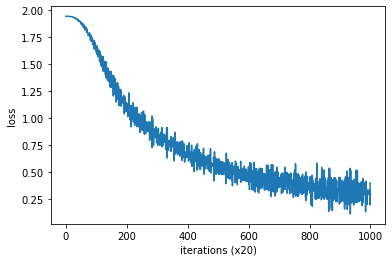

In [113]:
trainer.plot()

In [114]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id].numpy())

you [-0.7559733   0.8223706   1.7595266   0.82428426 -0.7417107 ]
say [ 1.6673946   0.28585762  0.36691344 -1.7274151   1.9685572 ]
goodbye [-1.5696769  1.6188371 -0.135139   1.7321404 -1.6519831]
and [ 1.1827497  2.315946   2.0437524 -1.4595901  1.1504059]
i [-1.5603639   1.6266162  -0.12618488  1.7150255  -1.6352584 ]
hello [-0.7619438   0.83408046  1.7539667   0.8280696  -0.7422945 ]
. [ 1.2357583 -1.3172857 -1.4190314 -1.0886376  1.2045853]


In [115]:
class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        W_in = tf.Variable(tf.random.normal((V, H), mean=0.0, stddev=0.01, dtype='float'))
        W_out = tf.Variable(tf.random.normal((H, V), mean=0.0, stddev=0.01, dtype='float'))

        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        layers = [
                self.in_layer,
                self.out_layer,
                self.loss_layer1,
                self.loss_layer2
        ]

        self.params = []
        self.grads = []
        for layer in layers:
            self.params += layer.params
            
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        self.grads = []
        layers = [
                self.in_layer,
                self.out_layer,
                self.loss_layer1,
                self.loss_layer2
        ]
        
        for layer in layers:
            self.grads += layer.grads
        
        return None


In [120]:
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 10000

text = 'you say goodbye and i say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleSkipGram(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [121]:
trainer.fit(contexts, target, max_epoch, batch_size)


| epoch 1 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 3.89
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 3.88
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 3.88
| epoch 21 |  iter 1 / 2 | ti

| epoch 206 |  iter 1 / 2 | time 1[s] | loss 2.62
| epoch 207 |  iter 1 / 2 | time 1[s] | loss 2.72
| epoch 208 |  iter 1 / 2 | time 1[s] | loss 2.86
| epoch 209 |  iter 1 / 2 | time 1[s] | loss 2.77
| epoch 210 |  iter 1 / 2 | time 1[s] | loss 2.60
| epoch 211 |  iter 1 / 2 | time 1[s] | loss 2.70
| epoch 212 |  iter 1 / 2 | time 1[s] | loss 2.74
| epoch 213 |  iter 1 / 2 | time 1[s] | loss 2.65
| epoch 214 |  iter 1 / 2 | time 1[s] | loss 2.68
| epoch 215 |  iter 1 / 2 | time 1[s] | loss 2.68
| epoch 216 |  iter 1 / 2 | time 1[s] | loss 2.68
| epoch 217 |  iter 1 / 2 | time 1[s] | loss 2.68
| epoch 218 |  iter 1 / 2 | time 1[s] | loss 2.75
| epoch 219 |  iter 1 / 2 | time 1[s] | loss 2.61
| epoch 220 |  iter 1 / 2 | time 1[s] | loss 2.73
| epoch 221 |  iter 1 / 2 | time 1[s] | loss 2.54
| epoch 222 |  iter 1 / 2 | time 1[s] | loss 2.71
| epoch 223 |  iter 1 / 2 | time 1[s] | loss 2.61
| epoch 224 |  iter 1 / 2 | time 1[s] | loss 2.70
| epoch 225 |  iter 1 / 2 | time 1[s] | loss 2.53


| epoch 406 |  iter 1 / 2 | time 2[s] | loss 2.38
| epoch 407 |  iter 1 / 2 | time 2[s] | loss 2.18
| epoch 408 |  iter 1 / 2 | time 2[s] | loss 2.38
| epoch 409 |  iter 1 / 2 | time 2[s] | loss 2.57
| epoch 410 |  iter 1 / 2 | time 2[s] | loss 2.18
| epoch 411 |  iter 1 / 2 | time 2[s] | loss 2.51
| epoch 412 |  iter 1 / 2 | time 2[s] | loss 2.31
| epoch 413 |  iter 1 / 2 | time 2[s] | loss 2.50
| epoch 414 |  iter 1 / 2 | time 2[s] | loss 2.18
| epoch 415 |  iter 1 / 2 | time 2[s] | loss 2.57
| epoch 416 |  iter 1 / 2 | time 2[s] | loss 2.24
| epoch 417 |  iter 1 / 2 | time 2[s] | loss 2.37
| epoch 418 |  iter 1 / 2 | time 2[s] | loss 2.50
| epoch 419 |  iter 1 / 2 | time 2[s] | loss 2.31
| epoch 420 |  iter 1 / 2 | time 2[s] | loss 2.24
| epoch 421 |  iter 1 / 2 | time 2[s] | loss 2.50
| epoch 422 |  iter 1 / 2 | time 2[s] | loss 2.23
| epoch 423 |  iter 1 / 2 | time 2[s] | loss 2.24
| epoch 424 |  iter 1 / 2 | time 2[s] | loss 2.63
| epoch 425 |  iter 1 / 2 | time 2[s] | loss 2.23


| epoch 607 |  iter 1 / 2 | time 3[s] | loss 2.20
| epoch 608 |  iter 1 / 2 | time 3[s] | loss 2.29
| epoch 609 |  iter 1 / 2 | time 3[s] | loss 2.11
| epoch 610 |  iter 1 / 2 | time 3[s] | loss 2.20
| epoch 611 |  iter 1 / 2 | time 3[s] | loss 2.06
| epoch 612 |  iter 1 / 2 | time 3[s] | loss 2.50
| epoch 613 |  iter 1 / 2 | time 3[s] | loss 2.25
| epoch 614 |  iter 1 / 2 | time 3[s] | loss 1.74
| epoch 615 |  iter 1 / 2 | time 3[s] | loss 2.23
| epoch 616 |  iter 1 / 2 | time 3[s] | loss 2.16
| epoch 617 |  iter 1 / 2 | time 3[s] | loss 2.45
| epoch 618 |  iter 1 / 2 | time 3[s] | loss 2.38
| epoch 619 |  iter 1 / 2 | time 3[s] | loss 2.13
| epoch 620 |  iter 1 / 2 | time 3[s] | loss 1.96
| epoch 621 |  iter 1 / 2 | time 3[s] | loss 2.27
| epoch 622 |  iter 1 / 2 | time 3[s] | loss 1.93
| epoch 623 |  iter 1 / 2 | time 3[s] | loss 2.22
| epoch 624 |  iter 1 / 2 | time 3[s] | loss 2.61
| epoch 625 |  iter 1 / 2 | time 3[s] | loss 2.13
| epoch 626 |  iter 1 / 2 | time 3[s] | loss 2.01


| epoch 809 |  iter 1 / 2 | time 4[s] | loss 1.79
| epoch 810 |  iter 1 / 2 | time 4[s] | loss 2.47
| epoch 811 |  iter 1 / 2 | time 4[s] | loss 1.79
| epoch 812 |  iter 1 / 2 | time 4[s] | loss 2.00
| epoch 813 |  iter 1 / 2 | time 4[s] | loss 1.85
| epoch 814 |  iter 1 / 2 | time 4[s] | loss 1.99
| epoch 815 |  iter 1 / 2 | time 4[s] | loss 2.24
| epoch 816 |  iter 1 / 2 | time 4[s] | loss 2.05
| epoch 817 |  iter 1 / 2 | time 4[s] | loss 2.02
| epoch 818 |  iter 1 / 2 | time 4[s] | loss 2.02
| epoch 819 |  iter 1 / 2 | time 4[s] | loss 1.80
| epoch 820 |  iter 1 / 2 | time 4[s] | loss 2.29
| epoch 821 |  iter 1 / 2 | time 4[s] | loss 2.00
| epoch 822 |  iter 1 / 2 | time 4[s] | loss 1.98
| epoch 823 |  iter 1 / 2 | time 4[s] | loss 2.28
| epoch 824 |  iter 1 / 2 | time 4[s] | loss 1.79
| epoch 825 |  iter 1 / 2 | time 4[s] | loss 1.81
| epoch 826 |  iter 1 / 2 | time 4[s] | loss 2.23
| epoch 827 |  iter 1 / 2 | time 4[s] | loss 2.02
| epoch 828 |  iter 1 / 2 | time 4[s] | loss 2.02


| epoch 1010 |  iter 1 / 2 | time 5[s] | loss 1.70
| epoch 1011 |  iter 1 / 2 | time 5[s] | loss 1.94
| epoch 1012 |  iter 1 / 2 | time 5[s] | loss 2.15
| epoch 1013 |  iter 1 / 2 | time 5[s] | loss 1.72
| epoch 1014 |  iter 1 / 2 | time 5[s] | loss 1.92
| epoch 1015 |  iter 1 / 2 | time 5[s] | loss 1.92
| epoch 1016 |  iter 1 / 2 | time 5[s] | loss 1.93
| epoch 1017 |  iter 1 / 2 | time 5[s] | loss 1.94
| epoch 1018 |  iter 1 / 2 | time 5[s] | loss 1.91
| epoch 1019 |  iter 1 / 2 | time 5[s] | loss 1.94
| epoch 1020 |  iter 1 / 2 | time 5[s] | loss 1.93
| epoch 1021 |  iter 1 / 2 | time 5[s] | loss 2.15
| epoch 1022 |  iter 1 / 2 | time 5[s] | loss 1.72
| epoch 1023 |  iter 1 / 2 | time 5[s] | loss 1.91
| epoch 1024 |  iter 1 / 2 | time 5[s] | loss 1.69
| epoch 1025 |  iter 1 / 2 | time 5[s] | loss 2.17
| epoch 1026 |  iter 1 / 2 | time 5[s] | loss 1.69
| epoch 1027 |  iter 1 / 2 | time 5[s] | loss 2.38
| epoch 1028 |  iter 1 / 2 | time 5[s] | loss 1.48
| epoch 1029 |  iter 1 / 2 | ti

| epoch 1173 |  iter 1 / 2 | time 5[s] | loss 2.13
| epoch 1174 |  iter 1 / 2 | time 5[s] | loss 2.11
| epoch 1175 |  iter 1 / 2 | time 5[s] | loss 1.67
| epoch 1176 |  iter 1 / 2 | time 5[s] | loss 1.89
| epoch 1177 |  iter 1 / 2 | time 5[s] | loss 1.67
| epoch 1178 |  iter 1 / 2 | time 5[s] | loss 2.35
| epoch 1179 |  iter 1 / 2 | time 5[s] | loss 1.66
| epoch 1180 |  iter 1 / 2 | time 5[s] | loss 1.90
| epoch 1181 |  iter 1 / 2 | time 5[s] | loss 1.67
| epoch 1182 |  iter 1 / 2 | time 5[s] | loss 2.12
| epoch 1183 |  iter 1 / 2 | time 5[s] | loss 1.89
| epoch 1184 |  iter 1 / 2 | time 5[s] | loss 1.89
| epoch 1185 |  iter 1 / 2 | time 5[s] | loss 2.12
| epoch 1186 |  iter 1 / 2 | time 5[s] | loss 1.44
| epoch 1187 |  iter 1 / 2 | time 5[s] | loss 2.11
| epoch 1188 |  iter 1 / 2 | time 5[s] | loss 1.89
| epoch 1189 |  iter 1 / 2 | time 5[s] | loss 1.90
| epoch 1190 |  iter 1 / 2 | time 5[s] | loss 1.89
| epoch 1191 |  iter 1 / 2 | time 5[s] | loss 1.88
| epoch 1192 |  iter 1 / 2 | ti

| epoch 1336 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1337 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1338 |  iter 1 / 2 | time 6[s] | loss 2.10
| epoch 1339 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1340 |  iter 1 / 2 | time 6[s] | loss 1.87
| epoch 1341 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1342 |  iter 1 / 2 | time 6[s] | loss 1.42
| epoch 1343 |  iter 1 / 2 | time 6[s] | loss 2.10
| epoch 1344 |  iter 1 / 2 | time 6[s] | loss 1.65
| epoch 1345 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1346 |  iter 1 / 2 | time 6[s] | loss 1.87
| epoch 1347 |  iter 1 / 2 | time 6[s] | loss 2.11
| epoch 1348 |  iter 1 / 2 | time 6[s] | loss 2.11
| epoch 1349 |  iter 1 / 2 | time 6[s] | loss 1.64
| epoch 1350 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1351 |  iter 1 / 2 | time 6[s] | loss 2.11
| epoch 1352 |  iter 1 / 2 | time 6[s] | loss 1.64
| epoch 1353 |  iter 1 / 2 | time 6[s] | loss 1.87
| epoch 1354 |  iter 1 / 2 | time 6[s] | loss 1.88
| epoch 1355 |  iter 1 / 2 | ti

| epoch 1498 |  iter 1 / 2 | time 7[s] | loss 2.10
| epoch 1499 |  iter 1 / 2 | time 7[s] | loss 1.87
| epoch 1500 |  iter 1 / 2 | time 7[s] | loss 1.87
| epoch 1501 |  iter 1 / 2 | time 7[s] | loss 2.10
| epoch 1502 |  iter 1 / 2 | time 7[s] | loss 1.64
| epoch 1503 |  iter 1 / 2 | time 7[s] | loss 1.86
| epoch 1504 |  iter 1 / 2 | time 7[s] | loss 2.10
| epoch 1505 |  iter 1 / 2 | time 7[s] | loss 1.64
| epoch 1506 |  iter 1 / 2 | time 7[s] | loss 1.87
| epoch 1507 |  iter 1 / 2 | time 7[s] | loss 1.87
| epoch 1508 |  iter 1 / 2 | time 7[s] | loss 1.64
| epoch 1509 |  iter 1 / 2 | time 7[s] | loss 2.10
| epoch 1510 |  iter 1 / 2 | time 7[s] | loss 1.64
| epoch 1511 |  iter 1 / 2 | time 7[s] | loss 2.10
| epoch 1512 |  iter 1 / 2 | time 7[s] | loss 1.64
| epoch 1513 |  iter 1 / 2 | time 7[s] | loss 1.87
| epoch 1514 |  iter 1 / 2 | time 7[s] | loss 2.10
| epoch 1515 |  iter 1 / 2 | time 7[s] | loss 1.87
| epoch 1516 |  iter 1 / 2 | time 7[s] | loss 1.87
| epoch 1517 |  iter 1 / 2 | ti

| epoch 1660 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1661 |  iter 1 / 2 | time 8[s] | loss 2.09
| epoch 1662 |  iter 1 / 2 | time 8[s] | loss 1.63
| epoch 1663 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1664 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1665 |  iter 1 / 2 | time 8[s] | loss 2.09
| epoch 1666 |  iter 1 / 2 | time 8[s] | loss 1.40
| epoch 1667 |  iter 1 / 2 | time 8[s] | loss 2.09
| epoch 1668 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1669 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1670 |  iter 1 / 2 | time 8[s] | loss 1.64
| epoch 1671 |  iter 1 / 2 | time 8[s] | loss 2.09
| epoch 1672 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1673 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1674 |  iter 1 / 2 | time 8[s] | loss 1.86
| epoch 1675 |  iter 1 / 2 | time 8[s] | loss 2.09
| epoch 1676 |  iter 1 / 2 | time 8[s] | loss 1.63
| epoch 1677 |  iter 1 / 2 | time 8[s] | loss 1.87
| epoch 1678 |  iter 1 / 2 | time 8[s] | loss 2.09
| epoch 1679 |  iter 1 / 2 | ti

| epoch 1860 |  iter 1 / 2 | time 9[s] | loss 2.09
| epoch 1861 |  iter 1 / 2 | time 9[s] | loss 1.40
| epoch 1862 |  iter 1 / 2 | time 9[s] | loss 2.09
| epoch 1863 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1864 |  iter 1 / 2 | time 9[s] | loss 2.09
| epoch 1865 |  iter 1 / 2 | time 9[s] | loss 1.63
| epoch 1866 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1867 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1868 |  iter 1 / 2 | time 9[s] | loss 2.09
| epoch 1869 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1870 |  iter 1 / 2 | time 9[s] | loss 1.63
| epoch 1871 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1872 |  iter 1 / 2 | time 9[s] | loss 2.09
| epoch 1873 |  iter 1 / 2 | time 9[s] | loss 1.40
| epoch 1874 |  iter 1 / 2 | time 9[s] | loss 2.32
| epoch 1875 |  iter 1 / 2 | time 9[s] | loss 1.62
| epoch 1876 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1877 |  iter 1 / 2 | time 9[s] | loss 1.86
| epoch 1878 |  iter 1 / 2 | time 9[s] | loss 2.09
| epoch 1879 |  iter 1 / 2 | ti

| epoch 2022 |  iter 1 / 2 | time 10[s] | loss 1.85
| epoch 2023 |  iter 1 / 2 | time 10[s] | loss 2.09
| epoch 2024 |  iter 1 / 2 | time 10[s] | loss 1.63
| epoch 2025 |  iter 1 / 2 | time 10[s] | loss 1.63
| epoch 2026 |  iter 1 / 2 | time 10[s] | loss 2.08
| epoch 2027 |  iter 1 / 2 | time 10[s] | loss 1.63
| epoch 2028 |  iter 1 / 2 | time 10[s] | loss 2.32
| epoch 2029 |  iter 1 / 2 | time 10[s] | loss 1.63
| epoch 2030 |  iter 1 / 2 | time 10[s] | loss 2.09
| epoch 2031 |  iter 1 / 2 | time 10[s] | loss 1.63
| epoch 2032 |  iter 1 / 2 | time 10[s] | loss 2.09
| epoch 2033 |  iter 1 / 2 | time 10[s] | loss 1.63
| epoch 2034 |  iter 1 / 2 | time 10[s] | loss 2.09
| epoch 2035 |  iter 1 / 2 | time 10[s] | loss 1.63
| epoch 2036 |  iter 1 / 2 | time 10[s] | loss 1.85
| epoch 2037 |  iter 1 / 2 | time 10[s] | loss 1.63
| epoch 2038 |  iter 1 / 2 | time 10[s] | loss 1.86
| epoch 2039 |  iter 1 / 2 | time 10[s] | loss 2.31
| epoch 2040 |  iter 1 / 2 | time 10[s] | loss 1.63
| epoch 2041

| epoch 2185 |  iter 1 / 2 | time 10[s] | loss 1.85
| epoch 2186 |  iter 1 / 2 | time 10[s] | loss 1.62
| epoch 2187 |  iter 1 / 2 | time 10[s] | loss 1.62
| epoch 2188 |  iter 1 / 2 | time 11[s] | loss 2.09
| epoch 2189 |  iter 1 / 2 | time 11[s] | loss 1.62
| epoch 2190 |  iter 1 / 2 | time 11[s] | loss 2.08
| epoch 2191 |  iter 1 / 2 | time 11[s] | loss 2.09
| epoch 2192 |  iter 1 / 2 | time 11[s] | loss 1.39
| epoch 2193 |  iter 1 / 2 | time 11[s] | loss 2.09
| epoch 2194 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2195 |  iter 1 / 2 | time 11[s] | loss 1.86
| epoch 2196 |  iter 1 / 2 | time 11[s] | loss 1.62
| epoch 2197 |  iter 1 / 2 | time 11[s] | loss 2.08
| epoch 2198 |  iter 1 / 2 | time 11[s] | loss 1.62
| epoch 2199 |  iter 1 / 2 | time 11[s] | loss 2.32
| epoch 2200 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2201 |  iter 1 / 2 | time 11[s] | loss 1.62
| epoch 2202 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2203 |  iter 1 / 2 | time 11[s] | loss 1.62
| epoch 2204

| epoch 2343 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2344 |  iter 1 / 2 | time 11[s] | loss 1.62
| epoch 2345 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2346 |  iter 1 / 2 | time 11[s] | loss 2.08
| epoch 2347 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2348 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2349 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2350 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2351 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2352 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2353 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2354 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2355 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2356 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2357 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2358 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2359 |  iter 1 / 2 | time 11[s] | loss 2.08
| epoch 2360 |  iter 1 / 2 | time 11[s] | loss 1.85
| epoch 2361 |  iter 1 / 2 | time 11[s] | loss 1.62
| epoch 2362

| epoch 2501 |  iter 1 / 2 | time 12[s] | loss 1.85
| epoch 2502 |  iter 1 / 2 | time 12[s] | loss 1.85
| epoch 2503 |  iter 1 / 2 | time 12[s] | loss 1.62
| epoch 2504 |  iter 1 / 2 | time 12[s] | loss 2.08
| epoch 2505 |  iter 1 / 2 | time 12[s] | loss 2.08
| epoch 2506 |  iter 1 / 2 | time 12[s] | loss 1.62
| epoch 2507 |  iter 1 / 2 | time 12[s] | loss 1.85
| epoch 2508 |  iter 1 / 2 | time 12[s] | loss 1.62
| epoch 2509 |  iter 1 / 2 | time 12[s] | loss 2.31
| epoch 2510 |  iter 1 / 2 | time 12[s] | loss 1.39
| epoch 2511 |  iter 1 / 2 | time 12[s] | loss 2.31
| epoch 2512 |  iter 1 / 2 | time 12[s] | loss 1.39
| epoch 2513 |  iter 1 / 2 | time 12[s] | loss 1.85
| epoch 2514 |  iter 1 / 2 | time 12[s] | loss 2.08
| epoch 2515 |  iter 1 / 2 | time 12[s] | loss 1.85
| epoch 2516 |  iter 1 / 2 | time 12[s] | loss 1.85
| epoch 2517 |  iter 1 / 2 | time 12[s] | loss 1.62
| epoch 2518 |  iter 1 / 2 | time 12[s] | loss 2.31
| epoch 2519 |  iter 1 / 2 | time 12[s] | loss 1.85
| epoch 2520

| epoch 2693 |  iter 1 / 2 | time 13[s] | loss 2.31
| epoch 2694 |  iter 1 / 2 | time 13[s] | loss 1.62
| epoch 2695 |  iter 1 / 2 | time 13[s] | loss 1.85
| epoch 2696 |  iter 1 / 2 | time 13[s] | loss 1.85
| epoch 2697 |  iter 1 / 2 | time 13[s] | loss 1.62
| epoch 2698 |  iter 1 / 2 | time 13[s] | loss 2.08
| epoch 2699 |  iter 1 / 2 | time 13[s] | loss 1.62
| epoch 2700 |  iter 1 / 2 | time 13[s] | loss 2.08
| epoch 2701 |  iter 1 / 2 | time 13[s] | loss 1.62
| epoch 2702 |  iter 1 / 2 | time 13[s] | loss 2.08
| epoch 2703 |  iter 1 / 2 | time 13[s] | loss 1.85
| epoch 2704 |  iter 1 / 2 | time 13[s] | loss 2.08
| epoch 2705 |  iter 1 / 2 | time 13[s] | loss 1.39
| epoch 2706 |  iter 1 / 2 | time 13[s] | loss 1.85
| epoch 2707 |  iter 1 / 2 | time 13[s] | loss 2.08
| epoch 2708 |  iter 1 / 2 | time 13[s] | loss 2.08
| epoch 2709 |  iter 1 / 2 | time 13[s] | loss 1.62
| epoch 2710 |  iter 1 / 2 | time 13[s] | loss 1.85
| epoch 2711 |  iter 1 / 2 | time 13[s] | loss 2.08
| epoch 2712

| epoch 2852 |  iter 1 / 2 | time 14[s] | loss 1.85
| epoch 2853 |  iter 1 / 2 | time 14[s] | loss 1.85
| epoch 2854 |  iter 1 / 2 | time 14[s] | loss 1.85
| epoch 2855 |  iter 1 / 2 | time 14[s] | loss 1.85
| epoch 2856 |  iter 1 / 2 | time 14[s] | loss 1.85
| epoch 2857 |  iter 1 / 2 | time 14[s] | loss 1.62
| epoch 2858 |  iter 1 / 2 | time 14[s] | loss 2.08
| epoch 2859 |  iter 1 / 2 | time 14[s] | loss 1.85
| epoch 2860 |  iter 1 / 2 | time 14[s] | loss 2.08
| epoch 2861 |  iter 1 / 2 | time 14[s] | loss 1.62
| epoch 2862 |  iter 1 / 2 | time 14[s] | loss 1.85
| epoch 2863 |  iter 1 / 2 | time 14[s] | loss 1.85
| epoch 2864 |  iter 1 / 2 | time 14[s] | loss 1.62
| epoch 2865 |  iter 1 / 2 | time 14[s] | loss 2.08
| epoch 2866 |  iter 1 / 2 | time 14[s] | loss 1.85
| epoch 2867 |  iter 1 / 2 | time 14[s] | loss 2.08
| epoch 2868 |  iter 1 / 2 | time 14[s] | loss 1.85
| epoch 2869 |  iter 1 / 2 | time 14[s] | loss 1.85
| epoch 2870 |  iter 1 / 2 | time 14[s] | loss 1.62
| epoch 2871

| epoch 3049 |  iter 1 / 2 | time 15[s] | loss 1.85
| epoch 3050 |  iter 1 / 2 | time 15[s] | loss 1.62
| epoch 3051 |  iter 1 / 2 | time 15[s] | loss 1.85
| epoch 3052 |  iter 1 / 2 | time 15[s] | loss 2.08
| epoch 3053 |  iter 1 / 2 | time 15[s] | loss 1.62
| epoch 3054 |  iter 1 / 2 | time 15[s] | loss 1.62
| epoch 3055 |  iter 1 / 2 | time 15[s] | loss 2.08
| epoch 3056 |  iter 1 / 2 | time 15[s] | loss 1.62
| epoch 3057 |  iter 1 / 2 | time 15[s] | loss 2.08
| epoch 3058 |  iter 1 / 2 | time 15[s] | loss 1.62
| epoch 3059 |  iter 1 / 2 | time 15[s] | loss 2.08
| epoch 3060 |  iter 1 / 2 | time 15[s] | loss 1.85
| epoch 3061 |  iter 1 / 2 | time 15[s] | loss 1.85
| epoch 3062 |  iter 1 / 2 | time 15[s] | loss 2.08
| epoch 3063 |  iter 1 / 2 | time 15[s] | loss 1.62
| epoch 3064 |  iter 1 / 2 | time 15[s] | loss 2.08
| epoch 3065 |  iter 1 / 2 | time 15[s] | loss 1.39
| epoch 3066 |  iter 1 / 2 | time 15[s] | loss 2.08
| epoch 3067 |  iter 1 / 2 | time 15[s] | loss 2.08
| epoch 3068

| epoch 3208 |  iter 1 / 2 | time 16[s] | loss 1.85
| epoch 3209 |  iter 1 / 2 | time 16[s] | loss 1.85
| epoch 3210 |  iter 1 / 2 | time 16[s] | loss 1.85
| epoch 3211 |  iter 1 / 2 | time 16[s] | loss 1.85
| epoch 3212 |  iter 1 / 2 | time 16[s] | loss 1.85
| epoch 3213 |  iter 1 / 2 | time 16[s] | loss 1.85
| epoch 3214 |  iter 1 / 2 | time 16[s] | loss 1.62
| epoch 3215 |  iter 1 / 2 | time 16[s] | loss 2.08
| epoch 3216 |  iter 1 / 2 | time 16[s] | loss 2.08
| epoch 3217 |  iter 1 / 2 | time 16[s] | loss 1.39
| epoch 3218 |  iter 1 / 2 | time 16[s] | loss 2.08
| epoch 3219 |  iter 1 / 2 | time 16[s] | loss 1.85
| epoch 3220 |  iter 1 / 2 | time 16[s] | loss 1.85
| epoch 3221 |  iter 1 / 2 | time 16[s] | loss 1.85
| epoch 3222 |  iter 1 / 2 | time 16[s] | loss 1.85
| epoch 3223 |  iter 1 / 2 | time 16[s] | loss 2.08
| epoch 3224 |  iter 1 / 2 | time 16[s] | loss 1.62
| epoch 3225 |  iter 1 / 2 | time 16[s] | loss 1.85
| epoch 3226 |  iter 1 / 2 | time 16[s] | loss 1.85
| epoch 3227

| epoch 3369 |  iter 1 / 2 | time 17[s] | loss 1.62
| epoch 3370 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3371 |  iter 1 / 2 | time 17[s] | loss 2.31
| epoch 3372 |  iter 1 / 2 | time 17[s] | loss 1.62
| epoch 3373 |  iter 1 / 2 | time 17[s] | loss 2.08
| epoch 3374 |  iter 1 / 2 | time 17[s] | loss 1.62
| epoch 3375 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3376 |  iter 1 / 2 | time 17[s] | loss 2.08
| epoch 3377 |  iter 1 / 2 | time 17[s] | loss 1.62
| epoch 3378 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3379 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3380 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3381 |  iter 1 / 2 | time 17[s] | loss 1.62
| epoch 3382 |  iter 1 / 2 | time 17[s] | loss 2.08
| epoch 3383 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3384 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3385 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3386 |  iter 1 / 2 | time 17[s] | loss 2.08
| epoch 3387 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3388

| epoch 3531 |  iter 1 / 2 | time 17[s] | loss 1.62
| epoch 3532 |  iter 1 / 2 | time 17[s] | loss 2.08
| epoch 3533 |  iter 1 / 2 | time 17[s] | loss 2.08
| epoch 3534 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3535 |  iter 1 / 2 | time 17[s] | loss 1.62
| epoch 3536 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3537 |  iter 1 / 2 | time 17[s] | loss 1.62
| epoch 3538 |  iter 1 / 2 | time 17[s] | loss 2.31
| epoch 3539 |  iter 1 / 2 | time 17[s] | loss 1.39
| epoch 3540 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3541 |  iter 1 / 2 | time 17[s] | loss 2.08
| epoch 3542 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3543 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3544 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3545 |  iter 1 / 2 | time 17[s] | loss 1.85
| epoch 3546 |  iter 1 / 2 | time 18[s] | loss 1.85
| epoch 3547 |  iter 1 / 2 | time 18[s] | loss 1.85
| epoch 3548 |  iter 1 / 2 | time 18[s] | loss 1.62
| epoch 3549 |  iter 1 / 2 | time 18[s] | loss 1.85
| epoch 3550

| epoch 3694 |  iter 1 / 2 | time 18[s] | loss 1.85
| epoch 3695 |  iter 1 / 2 | time 18[s] | loss 1.62
| epoch 3696 |  iter 1 / 2 | time 18[s] | loss 2.08
| epoch 3697 |  iter 1 / 2 | time 18[s] | loss 2.08
| epoch 3698 |  iter 1 / 2 | time 18[s] | loss 1.62
| epoch 3699 |  iter 1 / 2 | time 18[s] | loss 1.85
| epoch 3700 |  iter 1 / 2 | time 18[s] | loss 2.08
| epoch 3701 |  iter 1 / 2 | time 18[s] | loss 1.62
| epoch 3702 |  iter 1 / 2 | time 18[s] | loss 2.08
| epoch 3703 |  iter 1 / 2 | time 18[s] | loss 1.85
| epoch 3704 |  iter 1 / 2 | time 18[s] | loss 1.39
| epoch 3705 |  iter 1 / 2 | time 18[s] | loss 2.08
| epoch 3706 |  iter 1 / 2 | time 18[s] | loss 1.85
| epoch 3707 |  iter 1 / 2 | time 18[s] | loss 1.85
| epoch 3708 |  iter 1 / 2 | time 18[s] | loss 1.85
| epoch 3709 |  iter 1 / 2 | time 18[s] | loss 1.85
| epoch 3710 |  iter 1 / 2 | time 18[s] | loss 1.85
| epoch 3711 |  iter 1 / 2 | time 18[s] | loss 2.08
| epoch 3712 |  iter 1 / 2 | time 18[s] | loss 1.62
| epoch 3713

| epoch 3858 |  iter 1 / 2 | time 19[s] | loss 1.85
| epoch 3859 |  iter 1 / 2 | time 19[s] | loss 2.08
| epoch 3860 |  iter 1 / 2 | time 19[s] | loss 1.62
| epoch 3861 |  iter 1 / 2 | time 19[s] | loss 1.85
| epoch 3862 |  iter 1 / 2 | time 19[s] | loss 2.08
| epoch 3863 |  iter 1 / 2 | time 19[s] | loss 1.85
| epoch 3864 |  iter 1 / 2 | time 19[s] | loss 1.62
| epoch 3865 |  iter 1 / 2 | time 19[s] | loss 2.31
| epoch 3866 |  iter 1 / 2 | time 19[s] | loss 1.85
| epoch 3867 |  iter 1 / 2 | time 19[s] | loss 1.62
| epoch 3868 |  iter 1 / 2 | time 19[s] | loss 2.08
| epoch 3869 |  iter 1 / 2 | time 19[s] | loss 1.62
| epoch 3870 |  iter 1 / 2 | time 19[s] | loss 1.85
| epoch 3871 |  iter 1 / 2 | time 19[s] | loss 1.85
| epoch 3872 |  iter 1 / 2 | time 19[s] | loss 2.08
| epoch 3873 |  iter 1 / 2 | time 19[s] | loss 1.62
| epoch 3874 |  iter 1 / 2 | time 19[s] | loss 1.85
| epoch 3875 |  iter 1 / 2 | time 19[s] | loss 1.85
| epoch 3876 |  iter 1 / 2 | time 19[s] | loss 1.62
| epoch 3877

| epoch 4019 |  iter 1 / 2 | time 20[s] | loss 1.62
| epoch 4020 |  iter 1 / 2 | time 20[s] | loss 2.08
| epoch 4021 |  iter 1 / 2 | time 20[s] | loss 1.85
| epoch 4022 |  iter 1 / 2 | time 20[s] | loss 1.85
| epoch 4023 |  iter 1 / 2 | time 20[s] | loss 2.08
| epoch 4024 |  iter 1 / 2 | time 20[s] | loss 1.85
| epoch 4025 |  iter 1 / 2 | time 20[s] | loss 1.62
| epoch 4026 |  iter 1 / 2 | time 20[s] | loss 2.08
| epoch 4027 |  iter 1 / 2 | time 20[s] | loss 1.62
| epoch 4028 |  iter 1 / 2 | time 20[s] | loss 1.62
| epoch 4029 |  iter 1 / 2 | time 20[s] | loss 2.08
| epoch 4030 |  iter 1 / 2 | time 20[s] | loss 2.08
| epoch 4031 |  iter 1 / 2 | time 20[s] | loss 1.39
| epoch 4032 |  iter 1 / 2 | time 20[s] | loss 1.85
| epoch 4033 |  iter 1 / 2 | time 20[s] | loss 2.08
| epoch 4034 |  iter 1 / 2 | time 20[s] | loss 1.85
| epoch 4035 |  iter 1 / 2 | time 20[s] | loss 1.85
| epoch 4036 |  iter 1 / 2 | time 20[s] | loss 1.85
| epoch 4037 |  iter 1 / 2 | time 20[s] | loss 2.08
| epoch 4038

| epoch 4183 |  iter 1 / 2 | time 21[s] | loss 1.85
| epoch 4184 |  iter 1 / 2 | time 21[s] | loss 1.85
| epoch 4185 |  iter 1 / 2 | time 21[s] | loss 1.62
| epoch 4186 |  iter 1 / 2 | time 21[s] | loss 2.08
| epoch 4187 |  iter 1 / 2 | time 21[s] | loss 1.85
| epoch 4188 |  iter 1 / 2 | time 21[s] | loss 1.85
| epoch 4189 |  iter 1 / 2 | time 21[s] | loss 2.08
| epoch 4190 |  iter 1 / 2 | time 21[s] | loss 1.39
| epoch 4191 |  iter 1 / 2 | time 21[s] | loss 2.08
| epoch 4192 |  iter 1 / 2 | time 21[s] | loss 1.85
| epoch 4193 |  iter 1 / 2 | time 21[s] | loss 1.85
| epoch 4194 |  iter 1 / 2 | time 21[s] | loss 1.85
| epoch 4195 |  iter 1 / 2 | time 21[s] | loss 2.08
| epoch 4196 |  iter 1 / 2 | time 21[s] | loss 1.62
| epoch 4197 |  iter 1 / 2 | time 21[s] | loss 1.85
| epoch 4198 |  iter 1 / 2 | time 21[s] | loss 1.85
| epoch 4199 |  iter 1 / 2 | time 21[s] | loss 2.08
| epoch 4200 |  iter 1 / 2 | time 21[s] | loss 1.62
| epoch 4201 |  iter 1 / 2 | time 21[s] | loss 1.85
| epoch 4202

| epoch 4347 |  iter 1 / 2 | time 22[s] | loss 1.62
| epoch 4348 |  iter 1 / 2 | time 22[s] | loss 2.08
| epoch 4349 |  iter 1 / 2 | time 22[s] | loss 1.62
| epoch 4350 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4351 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4352 |  iter 1 / 2 | time 22[s] | loss 1.62
| epoch 4353 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4354 |  iter 1 / 2 | time 22[s] | loss 2.08
| epoch 4355 |  iter 1 / 2 | time 22[s] | loss 2.08
| epoch 4356 |  iter 1 / 2 | time 22[s] | loss 1.39
| epoch 4357 |  iter 1 / 2 | time 22[s] | loss 2.08
| epoch 4358 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4359 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4360 |  iter 1 / 2 | time 22[s] | loss 2.08
| epoch 4361 |  iter 1 / 2 | time 22[s] | loss 1.39
| epoch 4362 |  iter 1 / 2 | time 22[s] | loss 2.08
| epoch 4363 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4364 |  iter 1 / 2 | time 22[s] | loss 1.62
| epoch 4365 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4366

| epoch 4511 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4512 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4513 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4514 |  iter 1 / 2 | time 22[s] | loss 1.62
| epoch 4515 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4516 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4517 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4518 |  iter 1 / 2 | time 22[s] | loss 2.31
| epoch 4519 |  iter 1 / 2 | time 22[s] | loss 1.62
| epoch 4520 |  iter 1 / 2 | time 22[s] | loss 1.62
| epoch 4521 |  iter 1 / 2 | time 22[s] | loss 2.08
| epoch 4522 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4523 |  iter 1 / 2 | time 22[s] | loss 1.85
| epoch 4524 |  iter 1 / 2 | time 22[s] | loss 1.62
| epoch 4525 |  iter 1 / 2 | time 22[s] | loss 2.08
| epoch 4526 |  iter 1 / 2 | time 22[s] | loss 2.08
| epoch 4527 |  iter 1 / 2 | time 22[s] | loss 1.39
| epoch 4528 |  iter 1 / 2 | time 22[s] | loss 2.08
| epoch 4529 |  iter 1 / 2 | time 22[s] | loss 1.62
| epoch 4530

| epoch 4675 |  iter 1 / 2 | time 23[s] | loss 1.85
| epoch 4676 |  iter 1 / 2 | time 23[s] | loss 1.62
| epoch 4677 |  iter 1 / 2 | time 23[s] | loss 2.31
| epoch 4678 |  iter 1 / 2 | time 23[s] | loss 1.39
| epoch 4679 |  iter 1 / 2 | time 23[s] | loss 2.08
| epoch 4680 |  iter 1 / 2 | time 23[s] | loss 1.85
| epoch 4681 |  iter 1 / 2 | time 23[s] | loss 1.85
| epoch 4682 |  iter 1 / 2 | time 23[s] | loss 1.85
| epoch 4683 |  iter 1 / 2 | time 23[s] | loss 1.85
| epoch 4684 |  iter 1 / 2 | time 23[s] | loss 1.62
| epoch 4685 |  iter 1 / 2 | time 23[s] | loss 2.31
| epoch 4686 |  iter 1 / 2 | time 23[s] | loss 1.62
| epoch 4687 |  iter 1 / 2 | time 23[s] | loss 2.08
| epoch 4688 |  iter 1 / 2 | time 23[s] | loss 1.62
| epoch 4689 |  iter 1 / 2 | time 23[s] | loss 1.85
| epoch 4690 |  iter 1 / 2 | time 23[s] | loss 2.08
| epoch 4691 |  iter 1 / 2 | time 23[s] | loss 1.39
| epoch 4692 |  iter 1 / 2 | time 23[s] | loss 2.08
| epoch 4693 |  iter 1 / 2 | time 23[s] | loss 2.08
| epoch 4694

| epoch 4839 |  iter 1 / 2 | time 24[s] | loss 1.85
| epoch 4840 |  iter 1 / 2 | time 24[s] | loss 1.85
| epoch 4841 |  iter 1 / 2 | time 24[s] | loss 1.85
| epoch 4842 |  iter 1 / 2 | time 24[s] | loss 1.62
| epoch 4843 |  iter 1 / 2 | time 24[s] | loss 2.08
| epoch 4844 |  iter 1 / 2 | time 24[s] | loss 1.85
| epoch 4845 |  iter 1 / 2 | time 24[s] | loss 1.62
| epoch 4846 |  iter 1 / 2 | time 24[s] | loss 1.85
| epoch 4847 |  iter 1 / 2 | time 24[s] | loss 2.08
| epoch 4848 |  iter 1 / 2 | time 24[s] | loss 1.62
| epoch 4849 |  iter 1 / 2 | time 24[s] | loss 2.31
| epoch 4850 |  iter 1 / 2 | time 24[s] | loss 1.62
| epoch 4851 |  iter 1 / 2 | time 24[s] | loss 1.85
| epoch 4852 |  iter 1 / 2 | time 24[s] | loss 1.85
| epoch 4853 |  iter 1 / 2 | time 24[s] | loss 2.08
| epoch 4854 |  iter 1 / 2 | time 24[s] | loss 1.62
| epoch 4855 |  iter 1 / 2 | time 24[s] | loss 2.08
| epoch 4856 |  iter 1 / 2 | time 24[s] | loss 1.85
| epoch 4857 |  iter 1 / 2 | time 24[s] | loss 1.62
| epoch 4858

| epoch 5003 |  iter 1 / 2 | time 25[s] | loss 2.08
| epoch 5004 |  iter 1 / 2 | time 25[s] | loss 1.62
| epoch 5005 |  iter 1 / 2 | time 25[s] | loss 1.85
| epoch 5006 |  iter 1 / 2 | time 25[s] | loss 1.85
| epoch 5007 |  iter 1 / 2 | time 25[s] | loss 1.85
| epoch 5008 |  iter 1 / 2 | time 25[s] | loss 2.08
| epoch 5009 |  iter 1 / 2 | time 25[s] | loss 1.39
| epoch 5010 |  iter 1 / 2 | time 25[s] | loss 2.08
| epoch 5011 |  iter 1 / 2 | time 25[s] | loss 2.08
| epoch 5012 |  iter 1 / 2 | time 25[s] | loss 1.85
| epoch 5013 |  iter 1 / 2 | time 25[s] | loss 1.39
| epoch 5014 |  iter 1 / 2 | time 25[s] | loss 1.85
| epoch 5015 |  iter 1 / 2 | time 25[s] | loss 2.08
| epoch 5016 |  iter 1 / 2 | time 25[s] | loss 2.08
| epoch 5017 |  iter 1 / 2 | time 25[s] | loss 1.39
| epoch 5018 |  iter 1 / 2 | time 25[s] | loss 2.31
| epoch 5019 |  iter 1 / 2 | time 25[s] | loss 1.85
| epoch 5020 |  iter 1 / 2 | time 25[s] | loss 1.62
| epoch 5021 |  iter 1 / 2 | time 25[s] | loss 1.85
| epoch 5022

| epoch 5167 |  iter 1 / 2 | time 26[s] | loss 1.62
| epoch 5168 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5169 |  iter 1 / 2 | time 26[s] | loss 2.08
| epoch 5170 |  iter 1 / 2 | time 26[s] | loss 1.62
| epoch 5171 |  iter 1 / 2 | time 26[s] | loss 2.08
| epoch 5172 |  iter 1 / 2 | time 26[s] | loss 1.62
| epoch 5173 |  iter 1 / 2 | time 26[s] | loss 2.08
| epoch 5174 |  iter 1 / 2 | time 26[s] | loss 1.62
| epoch 5175 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5176 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5177 |  iter 1 / 2 | time 26[s] | loss 1.62
| epoch 5178 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5179 |  iter 1 / 2 | time 26[s] | loss 2.31
| epoch 5180 |  iter 1 / 2 | time 26[s] | loss 1.62
| epoch 5181 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5182 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5183 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5184 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5185 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5186

| epoch 5330 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5331 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5332 |  iter 1 / 2 | time 26[s] | loss 1.62
| epoch 5333 |  iter 1 / 2 | time 26[s] | loss 2.08
| epoch 5334 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5335 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5336 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5337 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5338 |  iter 1 / 2 | time 26[s] | loss 2.08
| epoch 5339 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5340 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5341 |  iter 1 / 2 | time 26[s] | loss 1.62
| epoch 5342 |  iter 1 / 2 | time 26[s] | loss 1.85
| epoch 5343 |  iter 1 / 2 | time 26[s] | loss 2.08
| epoch 5344 |  iter 1 / 2 | time 26[s] | loss 1.39
| epoch 5345 |  iter 1 / 2 | time 26[s] | loss 2.08
| epoch 5346 |  iter 1 / 2 | time 27[s] | loss 1.85
| epoch 5347 |  iter 1 / 2 | time 27[s] | loss 1.62
| epoch 5348 |  iter 1 / 2 | time 27[s] | loss 2.08
| epoch 5349

| epoch 5490 |  iter 1 / 2 | time 27[s] | loss 1.85
| epoch 5491 |  iter 1 / 2 | time 27[s] | loss 2.08
| epoch 5492 |  iter 1 / 2 | time 27[s] | loss 1.62
| epoch 5493 |  iter 1 / 2 | time 27[s] | loss 1.85
| epoch 5494 |  iter 1 / 2 | time 27[s] | loss 1.85
| epoch 5495 |  iter 1 / 2 | time 27[s] | loss 1.62
| epoch 5496 |  iter 1 / 2 | time 27[s] | loss 2.31
| epoch 5497 |  iter 1 / 2 | time 27[s] | loss 1.62
| epoch 5498 |  iter 1 / 2 | time 27[s] | loss 1.85
| epoch 5499 |  iter 1 / 2 | time 27[s] | loss 1.85
| epoch 5500 |  iter 1 / 2 | time 27[s] | loss 1.85
| epoch 5501 |  iter 1 / 2 | time 27[s] | loss 2.08
| epoch 5502 |  iter 1 / 2 | time 27[s] | loss 1.62
| epoch 5503 |  iter 1 / 2 | time 27[s] | loss 2.08
| epoch 5504 |  iter 1 / 2 | time 27[s] | loss 1.62
| epoch 5505 |  iter 1 / 2 | time 27[s] | loss 1.85
| epoch 5506 |  iter 1 / 2 | time 27[s] | loss 2.08
| epoch 5507 |  iter 1 / 2 | time 27[s] | loss 1.62
| epoch 5508 |  iter 1 / 2 | time 27[s] | loss 1.62
| epoch 5509

| epoch 5650 |  iter 1 / 2 | time 28[s] | loss 1.85
| epoch 5651 |  iter 1 / 2 | time 28[s] | loss 2.31
| epoch 5652 |  iter 1 / 2 | time 28[s] | loss 1.39
| epoch 5653 |  iter 1 / 2 | time 28[s] | loss 2.08
| epoch 5654 |  iter 1 / 2 | time 28[s] | loss 1.85
| epoch 5655 |  iter 1 / 2 | time 28[s] | loss 2.08
| epoch 5656 |  iter 1 / 2 | time 28[s] | loss 1.39
| epoch 5657 |  iter 1 / 2 | time 28[s] | loss 2.08
| epoch 5658 |  iter 1 / 2 | time 28[s] | loss 1.85
| epoch 5659 |  iter 1 / 2 | time 28[s] | loss 1.62
| epoch 5660 |  iter 1 / 2 | time 28[s] | loss 2.31
| epoch 5661 |  iter 1 / 2 | time 28[s] | loss 1.39
| epoch 5662 |  iter 1 / 2 | time 28[s] | loss 2.08
| epoch 5663 |  iter 1 / 2 | time 28[s] | loss 2.08
| epoch 5664 |  iter 1 / 2 | time 28[s] | loss 1.62
| epoch 5665 |  iter 1 / 2 | time 28[s] | loss 1.85
| epoch 5666 |  iter 1 / 2 | time 28[s] | loss 1.85
| epoch 5667 |  iter 1 / 2 | time 28[s] | loss 1.85
| epoch 5668 |  iter 1 / 2 | time 28[s] | loss 1.85
| epoch 5669

| epoch 5810 |  iter 1 / 2 | time 29[s] | loss 1.39
| epoch 5811 |  iter 1 / 2 | time 29[s] | loss 2.31
| epoch 5812 |  iter 1 / 2 | time 29[s] | loss 1.62
| epoch 5813 |  iter 1 / 2 | time 29[s] | loss 1.62
| epoch 5814 |  iter 1 / 2 | time 29[s] | loss 1.85
| epoch 5815 |  iter 1 / 2 | time 29[s] | loss 2.08
| epoch 5816 |  iter 1 / 2 | time 29[s] | loss 1.62
| epoch 5817 |  iter 1 / 2 | time 29[s] | loss 1.85
| epoch 5818 |  iter 1 / 2 | time 29[s] | loss 2.08
| epoch 5819 |  iter 1 / 2 | time 29[s] | loss 1.85
| epoch 5820 |  iter 1 / 2 | time 29[s] | loss 2.08
| epoch 5821 |  iter 1 / 2 | time 29[s] | loss 1.85
| epoch 5822 |  iter 1 / 2 | time 29[s] | loss 1.85
| epoch 5823 |  iter 1 / 2 | time 29[s] | loss 1.85
| epoch 5824 |  iter 1 / 2 | time 29[s] | loss 1.62
| epoch 5825 |  iter 1 / 2 | time 29[s] | loss 1.62
| epoch 5826 |  iter 1 / 2 | time 29[s] | loss 2.08
| epoch 5827 |  iter 1 / 2 | time 29[s] | loss 1.62
| epoch 5828 |  iter 1 / 2 | time 29[s] | loss 2.08
| epoch 5829

| epoch 5970 |  iter 1 / 2 | time 30[s] | loss 1.62
| epoch 5971 |  iter 1 / 2 | time 30[s] | loss 1.85
| epoch 5972 |  iter 1 / 2 | time 30[s] | loss 2.08
| epoch 5973 |  iter 1 / 2 | time 30[s] | loss 1.62
| epoch 5974 |  iter 1 / 2 | time 30[s] | loss 2.08
| epoch 5975 |  iter 1 / 2 | time 30[s] | loss 2.08
| epoch 5976 |  iter 1 / 2 | time 30[s] | loss 1.62
| epoch 5977 |  iter 1 / 2 | time 30[s] | loss 1.85
| epoch 5978 |  iter 1 / 2 | time 30[s] | loss 1.85
| epoch 5979 |  iter 1 / 2 | time 30[s] | loss 1.85
| epoch 5980 |  iter 1 / 2 | time 30[s] | loss 1.62
| epoch 5981 |  iter 1 / 2 | time 30[s] | loss 2.08
| epoch 5982 |  iter 1 / 2 | time 30[s] | loss 1.85
| epoch 5983 |  iter 1 / 2 | time 30[s] | loss 1.85
| epoch 5984 |  iter 1 / 2 | time 30[s] | loss 1.62
| epoch 5985 |  iter 1 / 2 | time 30[s] | loss 2.08
| epoch 5986 |  iter 1 / 2 | time 30[s] | loss 1.85
| epoch 5987 |  iter 1 / 2 | time 30[s] | loss 1.85
| epoch 5988 |  iter 1 / 2 | time 30[s] | loss 1.62
| epoch 5989

| epoch 6130 |  iter 1 / 2 | time 30[s] | loss 2.08
| epoch 6131 |  iter 1 / 2 | time 31[s] | loss 1.62
| epoch 6132 |  iter 1 / 2 | time 31[s] | loss 2.08
| epoch 6133 |  iter 1 / 2 | time 31[s] | loss 1.85
| epoch 6134 |  iter 1 / 2 | time 31[s] | loss 1.85
| epoch 6135 |  iter 1 / 2 | time 31[s] | loss 1.85
| epoch 6136 |  iter 1 / 2 | time 31[s] | loss 1.85
| epoch 6137 |  iter 1 / 2 | time 31[s] | loss 2.08
| epoch 6138 |  iter 1 / 2 | time 31[s] | loss 1.62
| epoch 6139 |  iter 1 / 2 | time 31[s] | loss 1.85
| epoch 6140 |  iter 1 / 2 | time 31[s] | loss 2.08
| epoch 6141 |  iter 1 / 2 | time 31[s] | loss 1.62
| epoch 6142 |  iter 1 / 2 | time 31[s] | loss 1.62
| epoch 6143 |  iter 1 / 2 | time 31[s] | loss 2.31
| epoch 6144 |  iter 1 / 2 | time 31[s] | loss 1.62
| epoch 6145 |  iter 1 / 2 | time 31[s] | loss 1.85
| epoch 6146 |  iter 1 / 2 | time 31[s] | loss 1.85
| epoch 6147 |  iter 1 / 2 | time 31[s] | loss 2.08
| epoch 6148 |  iter 1 / 2 | time 31[s] | loss 1.62
| epoch 6149

| epoch 6290 |  iter 1 / 2 | time 31[s] | loss 1.85
| epoch 6291 |  iter 1 / 2 | time 31[s] | loss 1.85
| epoch 6292 |  iter 1 / 2 | time 31[s] | loss 1.85
| epoch 6293 |  iter 1 / 2 | time 31[s] | loss 1.62
| epoch 6294 |  iter 1 / 2 | time 31[s] | loss 2.31
| epoch 6295 |  iter 1 / 2 | time 31[s] | loss 1.39
| epoch 6296 |  iter 1 / 2 | time 31[s] | loss 2.08
| epoch 6297 |  iter 1 / 2 | time 31[s] | loss 1.85
| epoch 6298 |  iter 1 / 2 | time 31[s] | loss 1.85
| epoch 6299 |  iter 1 / 2 | time 31[s] | loss 1.62
| epoch 6300 |  iter 1 / 2 | time 31[s] | loss 2.08
| epoch 6301 |  iter 1 / 2 | time 31[s] | loss 2.08
| epoch 6302 |  iter 1 / 2 | time 31[s] | loss 1.62
| epoch 6303 |  iter 1 / 2 | time 31[s] | loss 1.85
| epoch 6304 |  iter 1 / 2 | time 31[s] | loss 1.85
| epoch 6305 |  iter 1 / 2 | time 31[s] | loss 2.08
| epoch 6306 |  iter 1 / 2 | time 31[s] | loss 1.39
| epoch 6307 |  iter 1 / 2 | time 31[s] | loss 2.31
| epoch 6308 |  iter 1 / 2 | time 31[s] | loss 1.62
| epoch 6309

| epoch 6449 |  iter 1 / 2 | time 32[s] | loss 2.08
| epoch 6450 |  iter 1 / 2 | time 32[s] | loss 1.85
| epoch 6451 |  iter 1 / 2 | time 32[s] | loss 1.62
| epoch 6452 |  iter 1 / 2 | time 32[s] | loss 2.08
| epoch 6453 |  iter 1 / 2 | time 32[s] | loss 1.85
| epoch 6454 |  iter 1 / 2 | time 32[s] | loss 1.62
| epoch 6455 |  iter 1 / 2 | time 32[s] | loss 1.85
| epoch 6456 |  iter 1 / 2 | time 32[s] | loss 2.08
| epoch 6457 |  iter 1 / 2 | time 32[s] | loss 1.62
| epoch 6458 |  iter 1 / 2 | time 32[s] | loss 2.08
| epoch 6459 |  iter 1 / 2 | time 32[s] | loss 1.85
| epoch 6460 |  iter 1 / 2 | time 32[s] | loss 1.85
| epoch 6461 |  iter 1 / 2 | time 32[s] | loss 1.62
| epoch 6462 |  iter 1 / 2 | time 32[s] | loss 2.31
| epoch 6463 |  iter 1 / 2 | time 32[s] | loss 1.62
| epoch 6464 |  iter 1 / 2 | time 32[s] | loss 1.85
| epoch 6465 |  iter 1 / 2 | time 32[s] | loss 1.62
| epoch 6466 |  iter 1 / 2 | time 32[s] | loss 2.08
| epoch 6467 |  iter 1 / 2 | time 32[s] | loss 1.85
| epoch 6468

| epoch 6609 |  iter 1 / 2 | time 33[s] | loss 2.08
| epoch 6610 |  iter 1 / 2 | time 33[s] | loss 1.62
| epoch 6611 |  iter 1 / 2 | time 33[s] | loss 1.85
| epoch 6612 |  iter 1 / 2 | time 33[s] | loss 1.85
| epoch 6613 |  iter 1 / 2 | time 33[s] | loss 1.62
| epoch 6614 |  iter 1 / 2 | time 33[s] | loss 2.08
| epoch 6615 |  iter 1 / 2 | time 33[s] | loss 1.85
| epoch 6616 |  iter 1 / 2 | time 33[s] | loss 1.85
| epoch 6617 |  iter 1 / 2 | time 33[s] | loss 1.62
| epoch 6618 |  iter 1 / 2 | time 33[s] | loss 2.08
| epoch 6619 |  iter 1 / 2 | time 33[s] | loss 1.85
| epoch 6620 |  iter 1 / 2 | time 33[s] | loss 1.62
| epoch 6621 |  iter 1 / 2 | time 33[s] | loss 1.85
| epoch 6622 |  iter 1 / 2 | time 33[s] | loss 2.08
| epoch 6623 |  iter 1 / 2 | time 33[s] | loss 1.85
| epoch 6624 |  iter 1 / 2 | time 33[s] | loss 1.85
| epoch 6625 |  iter 1 / 2 | time 33[s] | loss 1.85
| epoch 6626 |  iter 1 / 2 | time 33[s] | loss 1.62
| epoch 6627 |  iter 1 / 2 | time 33[s] | loss 2.08
| epoch 6628

| epoch 6769 |  iter 1 / 2 | time 34[s] | loss 1.62
| epoch 6770 |  iter 1 / 2 | time 34[s] | loss 1.62
| epoch 6771 |  iter 1 / 2 | time 34[s] | loss 2.31
| epoch 6772 |  iter 1 / 2 | time 34[s] | loss 1.62
| epoch 6773 |  iter 1 / 2 | time 34[s] | loss 2.08
| epoch 6774 |  iter 1 / 2 | time 34[s] | loss 1.62
| epoch 6775 |  iter 1 / 2 | time 34[s] | loss 1.85
| epoch 6776 |  iter 1 / 2 | time 34[s] | loss 1.85
| epoch 6777 |  iter 1 / 2 | time 34[s] | loss 1.85
| epoch 6778 |  iter 1 / 2 | time 34[s] | loss 1.85
| epoch 6779 |  iter 1 / 2 | time 34[s] | loss 1.85
| epoch 6780 |  iter 1 / 2 | time 34[s] | loss 2.08
| epoch 6781 |  iter 1 / 2 | time 34[s] | loss 1.39
| epoch 6782 |  iter 1 / 2 | time 34[s] | loss 2.08
| epoch 6783 |  iter 1 / 2 | time 34[s] | loss 1.85
| epoch 6784 |  iter 1 / 2 | time 34[s] | loss 2.08
| epoch 6785 |  iter 1 / 2 | time 34[s] | loss 1.85
| epoch 6786 |  iter 1 / 2 | time 34[s] | loss 1.62
| epoch 6787 |  iter 1 / 2 | time 34[s] | loss 1.85
| epoch 6788

| epoch 6929 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 6930 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 6931 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 6932 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 6933 |  iter 1 / 2 | time 35[s] | loss 2.08
| epoch 6934 |  iter 1 / 2 | time 35[s] | loss 1.62
| epoch 6935 |  iter 1 / 2 | time 35[s] | loss 2.08
| epoch 6936 |  iter 1 / 2 | time 35[s] | loss 1.62
| epoch 6937 |  iter 1 / 2 | time 35[s] | loss 1.62
| epoch 6938 |  iter 1 / 2 | time 35[s] | loss 2.08
| epoch 6939 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 6940 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 6941 |  iter 1 / 2 | time 35[s] | loss 2.08
| epoch 6942 |  iter 1 / 2 | time 35[s] | loss 1.62
| epoch 6943 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 6944 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 6945 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 6946 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 6947 |  iter 1 / 2 | time 35[s] | loss 2.08
| epoch 6948

| epoch 7089 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 7090 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 7091 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 7092 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 7093 |  iter 1 / 2 | time 35[s] | loss 2.08
| epoch 7094 |  iter 1 / 2 | time 35[s] | loss 1.62
| epoch 7095 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 7096 |  iter 1 / 2 | time 35[s] | loss 1.62
| epoch 7097 |  iter 1 / 2 | time 35[s] | loss 2.31
| epoch 7098 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 7099 |  iter 1 / 2 | time 35[s] | loss 1.62
| epoch 7100 |  iter 1 / 2 | time 35[s] | loss 1.62
| epoch 7101 |  iter 1 / 2 | time 35[s] | loss 2.08
| epoch 7102 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 7103 |  iter 1 / 2 | time 35[s] | loss 2.08
| epoch 7104 |  iter 1 / 2 | time 35[s] | loss 1.62
| epoch 7105 |  iter 1 / 2 | time 35[s] | loss 2.08
| epoch 7106 |  iter 1 / 2 | time 35[s] | loss 1.62
| epoch 7107 |  iter 1 / 2 | time 35[s] | loss 1.85
| epoch 7108

| epoch 7249 |  iter 1 / 2 | time 36[s] | loss 1.85
| epoch 7250 |  iter 1 / 2 | time 36[s] | loss 1.85
| epoch 7251 |  iter 1 / 2 | time 36[s] | loss 1.85
| epoch 7252 |  iter 1 / 2 | time 36[s] | loss 1.85
| epoch 7253 |  iter 1 / 2 | time 36[s] | loss 1.85
| epoch 7254 |  iter 1 / 2 | time 36[s] | loss 1.85
| epoch 7255 |  iter 1 / 2 | time 36[s] | loss 2.08
| epoch 7256 |  iter 1 / 2 | time 36[s] | loss 1.62
| epoch 7257 |  iter 1 / 2 | time 36[s] | loss 1.85
| epoch 7258 |  iter 1 / 2 | time 36[s] | loss 1.85
| epoch 7259 |  iter 1 / 2 | time 36[s] | loss 2.08
| epoch 7260 |  iter 1 / 2 | time 36[s] | loss 1.85
| epoch 7261 |  iter 1 / 2 | time 36[s] | loss 1.62
| epoch 7262 |  iter 1 / 2 | time 36[s] | loss 1.85
| epoch 7263 |  iter 1 / 2 | time 36[s] | loss 1.85
| epoch 7264 |  iter 1 / 2 | time 36[s] | loss 2.08
| epoch 7265 |  iter 1 / 2 | time 36[s] | loss 1.62
| epoch 7266 |  iter 1 / 2 | time 36[s] | loss 1.85
| epoch 7267 |  iter 1 / 2 | time 36[s] | loss 1.85
| epoch 7268

| epoch 7409 |  iter 1 / 2 | time 37[s] | loss 1.85
| epoch 7410 |  iter 1 / 2 | time 37[s] | loss 1.62
| epoch 7411 |  iter 1 / 2 | time 37[s] | loss 1.85
| epoch 7412 |  iter 1 / 2 | time 37[s] | loss 1.85
| epoch 7413 |  iter 1 / 2 | time 37[s] | loss 1.85
| epoch 7414 |  iter 1 / 2 | time 37[s] | loss 2.08
| epoch 7415 |  iter 1 / 2 | time 37[s] | loss 1.39
| epoch 7416 |  iter 1 / 2 | time 37[s] | loss 1.85
| epoch 7417 |  iter 1 / 2 | time 37[s] | loss 1.85
| epoch 7418 |  iter 1 / 2 | time 37[s] | loss 2.31
| epoch 7419 |  iter 1 / 2 | time 37[s] | loss 1.62
| epoch 7420 |  iter 1 / 2 | time 37[s] | loss 1.62
| epoch 7421 |  iter 1 / 2 | time 37[s] | loss 2.31
| epoch 7422 |  iter 1 / 2 | time 37[s] | loss 1.62
| epoch 7423 |  iter 1 / 2 | time 37[s] | loss 1.85
| epoch 7424 |  iter 1 / 2 | time 37[s] | loss 1.85
| epoch 7425 |  iter 1 / 2 | time 37[s] | loss 1.85
| epoch 7426 |  iter 1 / 2 | time 37[s] | loss 1.62
| epoch 7427 |  iter 1 / 2 | time 37[s] | loss 2.08
| epoch 7428

| epoch 7571 |  iter 1 / 2 | time 38[s] | loss 1.85
| epoch 7572 |  iter 1 / 2 | time 38[s] | loss 1.85
| epoch 7573 |  iter 1 / 2 | time 38[s] | loss 1.85
| epoch 7574 |  iter 1 / 2 | time 38[s] | loss 1.62
| epoch 7575 |  iter 1 / 2 | time 38[s] | loss 2.08
| epoch 7576 |  iter 1 / 2 | time 38[s] | loss 2.08
| epoch 7577 |  iter 1 / 2 | time 38[s] | loss 1.62
| epoch 7578 |  iter 1 / 2 | time 38[s] | loss 2.08
| epoch 7579 |  iter 1 / 2 | time 38[s] | loss 1.62
| epoch 7580 |  iter 1 / 2 | time 38[s] | loss 1.85
| epoch 7581 |  iter 1 / 2 | time 38[s] | loss 1.85
| epoch 7582 |  iter 1 / 2 | time 38[s] | loss 1.85
| epoch 7583 |  iter 1 / 2 | time 38[s] | loss 1.85
| epoch 7584 |  iter 1 / 2 | time 38[s] | loss 1.62
| epoch 7585 |  iter 1 / 2 | time 38[s] | loss 2.08
| epoch 7586 |  iter 1 / 2 | time 38[s] | loss 1.85
| epoch 7587 |  iter 1 / 2 | time 38[s] | loss 1.85
| epoch 7588 |  iter 1 / 2 | time 38[s] | loss 2.08
| epoch 7589 |  iter 1 / 2 | time 38[s] | loss 1.62
| epoch 7590

| epoch 7734 |  iter 1 / 2 | time 39[s] | loss 2.08
| epoch 7735 |  iter 1 / 2 | time 39[s] | loss 1.39
| epoch 7736 |  iter 1 / 2 | time 39[s] | loss 1.85
| epoch 7737 |  iter 1 / 2 | time 39[s] | loss 2.08
| epoch 7738 |  iter 1 / 2 | time 39[s] | loss 1.85
| epoch 7739 |  iter 1 / 2 | time 39[s] | loss 2.08
| epoch 7740 |  iter 1 / 2 | time 39[s] | loss 1.62
| epoch 7741 |  iter 1 / 2 | time 39[s] | loss 1.85
| epoch 7742 |  iter 1 / 2 | time 39[s] | loss 1.62
| epoch 7743 |  iter 1 / 2 | time 39[s] | loss 2.08
| epoch 7744 |  iter 1 / 2 | time 39[s] | loss 1.85
| epoch 7745 |  iter 1 / 2 | time 39[s] | loss 1.85
| epoch 7746 |  iter 1 / 2 | time 39[s] | loss 1.62
| epoch 7747 |  iter 1 / 2 | time 39[s] | loss 2.08
| epoch 7748 |  iter 1 / 2 | time 39[s] | loss 1.85
| epoch 7749 |  iter 1 / 2 | time 39[s] | loss 1.85
| epoch 7750 |  iter 1 / 2 | time 39[s] | loss 1.85
| epoch 7751 |  iter 1 / 2 | time 39[s] | loss 1.85
| epoch 7752 |  iter 1 / 2 | time 39[s] | loss 2.08
| epoch 7753

| epoch 7897 |  iter 1 / 2 | time 39[s] | loss 1.85
| epoch 7898 |  iter 1 / 2 | time 39[s] | loss 1.85
| epoch 7899 |  iter 1 / 2 | time 39[s] | loss 2.08
| epoch 7900 |  iter 1 / 2 | time 39[s] | loss 1.39
| epoch 7901 |  iter 1 / 2 | time 39[s] | loss 2.31
| epoch 7902 |  iter 1 / 2 | time 39[s] | loss 1.85
| epoch 7903 |  iter 1 / 2 | time 39[s] | loss 1.85
| epoch 7904 |  iter 1 / 2 | time 39[s] | loss 1.39
| epoch 7905 |  iter 1 / 2 | time 39[s] | loss 2.08
| epoch 7906 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 7907 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 7908 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 7909 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 7910 |  iter 1 / 2 | time 40[s] | loss 1.62
| epoch 7911 |  iter 1 / 2 | time 40[s] | loss 2.08
| epoch 7912 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 7913 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 7914 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 7915 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 7916

| epoch 8057 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 8058 |  iter 1 / 2 | time 40[s] | loss 1.62
| epoch 8059 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 8060 |  iter 1 / 2 | time 40[s] | loss 2.08
| epoch 8061 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 8062 |  iter 1 / 2 | time 40[s] | loss 1.62
| epoch 8063 |  iter 1 / 2 | time 40[s] | loss 2.08
| epoch 8064 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 8065 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 8066 |  iter 1 / 2 | time 40[s] | loss 1.62
| epoch 8067 |  iter 1 / 2 | time 40[s] | loss 2.31
| epoch 8068 |  iter 1 / 2 | time 40[s] | loss 1.39
| epoch 8069 |  iter 1 / 2 | time 40[s] | loss 2.08
| epoch 8070 |  iter 1 / 2 | time 40[s] | loss 1.62
| epoch 8071 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 8072 |  iter 1 / 2 | time 40[s] | loss 2.08
| epoch 8073 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 8074 |  iter 1 / 2 | time 40[s] | loss 1.85
| epoch 8075 |  iter 1 / 2 | time 40[s] | loss 2.08
| epoch 8076

| epoch 8217 |  iter 1 / 2 | time 41[s] | loss 1.62
| epoch 8218 |  iter 1 / 2 | time 41[s] | loss 1.62
| epoch 8219 |  iter 1 / 2 | time 41[s] | loss 2.31
| epoch 8220 |  iter 1 / 2 | time 41[s] | loss 1.62
| epoch 8221 |  iter 1 / 2 | time 41[s] | loss 2.08
| epoch 8222 |  iter 1 / 2 | time 41[s] | loss 1.85
| epoch 8223 |  iter 1 / 2 | time 41[s] | loss 1.62
| epoch 8224 |  iter 1 / 2 | time 41[s] | loss 1.85
| epoch 8225 |  iter 1 / 2 | time 41[s] | loss 1.62
| epoch 8226 |  iter 1 / 2 | time 41[s] | loss 2.08
| epoch 8227 |  iter 1 / 2 | time 41[s] | loss 1.85
| epoch 8228 |  iter 1 / 2 | time 41[s] | loss 1.85
| epoch 8229 |  iter 1 / 2 | time 41[s] | loss 1.85
| epoch 8230 |  iter 1 / 2 | time 41[s] | loss 1.85
| epoch 8231 |  iter 1 / 2 | time 41[s] | loss 1.62
| epoch 8232 |  iter 1 / 2 | time 41[s] | loss 2.08
| epoch 8233 |  iter 1 / 2 | time 41[s] | loss 1.85
| epoch 8234 |  iter 1 / 2 | time 41[s] | loss 1.62
| epoch 8235 |  iter 1 / 2 | time 41[s] | loss 1.85
| epoch 8236

| epoch 8377 |  iter 1 / 2 | time 42[s] | loss 1.85
| epoch 8378 |  iter 1 / 2 | time 42[s] | loss 2.08
| epoch 8379 |  iter 1 / 2 | time 42[s] | loss 1.62
| epoch 8380 |  iter 1 / 2 | time 42[s] | loss 1.62
| epoch 8381 |  iter 1 / 2 | time 42[s] | loss 2.08
| epoch 8382 |  iter 1 / 2 | time 42[s] | loss 1.62
| epoch 8383 |  iter 1 / 2 | time 42[s] | loss 2.31
| epoch 8384 |  iter 1 / 2 | time 42[s] | loss 1.85
| epoch 8385 |  iter 1 / 2 | time 42[s] | loss 1.85
| epoch 8386 |  iter 1 / 2 | time 42[s] | loss 1.62
| epoch 8387 |  iter 1 / 2 | time 42[s] | loss 2.08
| epoch 8388 |  iter 1 / 2 | time 42[s] | loss 1.62
| epoch 8389 |  iter 1 / 2 | time 42[s] | loss 2.08
| epoch 8390 |  iter 1 / 2 | time 42[s] | loss 1.62
| epoch 8391 |  iter 1 / 2 | time 42[s] | loss 1.85
| epoch 8392 |  iter 1 / 2 | time 42[s] | loss 1.62
| epoch 8393 |  iter 1 / 2 | time 42[s] | loss 2.08
| epoch 8394 |  iter 1 / 2 | time 42[s] | loss 1.85
| epoch 8395 |  iter 1 / 2 | time 42[s] | loss 2.08
| epoch 8396

| epoch 8537 |  iter 1 / 2 | time 43[s] | loss 2.08
| epoch 8538 |  iter 1 / 2 | time 43[s] | loss 1.62
| epoch 8539 |  iter 1 / 2 | time 43[s] | loss 1.85
| epoch 8540 |  iter 1 / 2 | time 43[s] | loss 2.08
| epoch 8541 |  iter 1 / 2 | time 43[s] | loss 1.62
| epoch 8542 |  iter 1 / 2 | time 43[s] | loss 1.85
| epoch 8543 |  iter 1 / 2 | time 43[s] | loss 1.85
| epoch 8544 |  iter 1 / 2 | time 43[s] | loss 1.62
| epoch 8545 |  iter 1 / 2 | time 43[s] | loss 2.08
| epoch 8546 |  iter 1 / 2 | time 43[s] | loss 1.62
| epoch 8547 |  iter 1 / 2 | time 43[s] | loss 2.08
| epoch 8548 |  iter 1 / 2 | time 43[s] | loss 1.62
| epoch 8549 |  iter 1 / 2 | time 43[s] | loss 2.08
| epoch 8550 |  iter 1 / 2 | time 43[s] | loss 1.85
| epoch 8551 |  iter 1 / 2 | time 43[s] | loss 1.85
| epoch 8552 |  iter 1 / 2 | time 43[s] | loss 1.85
| epoch 8553 |  iter 1 / 2 | time 43[s] | loss 1.85
| epoch 8554 |  iter 1 / 2 | time 43[s] | loss 1.85
| epoch 8555 |  iter 1 / 2 | time 43[s] | loss 2.08
| epoch 8556

| epoch 8697 |  iter 1 / 2 | time 44[s] | loss 2.08
| epoch 8698 |  iter 1 / 2 | time 44[s] | loss 1.62
| epoch 8699 |  iter 1 / 2 | time 44[s] | loss 2.08
| epoch 8700 |  iter 1 / 2 | time 44[s] | loss 2.08
| epoch 8701 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8702 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8703 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8704 |  iter 1 / 2 | time 44[s] | loss 1.39
| epoch 8705 |  iter 1 / 2 | time 44[s] | loss 2.08
| epoch 8706 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8707 |  iter 1 / 2 | time 44[s] | loss 2.08
| epoch 8708 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8709 |  iter 1 / 2 | time 44[s] | loss 1.62
| epoch 8710 |  iter 1 / 2 | time 44[s] | loss 2.08
| epoch 8711 |  iter 1 / 2 | time 44[s] | loss 1.39
| epoch 8712 |  iter 1 / 2 | time 44[s] | loss 2.08
| epoch 8713 |  iter 1 / 2 | time 44[s] | loss 1.62
| epoch 8714 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8715 |  iter 1 / 2 | time 44[s] | loss 2.31
| epoch 8716

| epoch 8858 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8859 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8860 |  iter 1 / 2 | time 44[s] | loss 1.62
| epoch 8861 |  iter 1 / 2 | time 44[s] | loss 2.08
| epoch 8862 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8863 |  iter 1 / 2 | time 44[s] | loss 2.08
| epoch 8864 |  iter 1 / 2 | time 44[s] | loss 1.62
| epoch 8865 |  iter 1 / 2 | time 44[s] | loss 2.08
| epoch 8866 |  iter 1 / 2 | time 44[s] | loss 1.62
| epoch 8867 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8868 |  iter 1 / 2 | time 44[s] | loss 2.08
| epoch 8869 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8870 |  iter 1 / 2 | time 44[s] | loss 1.39
| epoch 8871 |  iter 1 / 2 | time 44[s] | loss 2.31
| epoch 8872 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8873 |  iter 1 / 2 | time 44[s] | loss 1.62
| epoch 8874 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8875 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8876 |  iter 1 / 2 | time 44[s] | loss 1.85
| epoch 8877

| epoch 9022 |  iter 1 / 2 | time 45[s] | loss 2.31
| epoch 9023 |  iter 1 / 2 | time 45[s] | loss 1.62
| epoch 9024 |  iter 1 / 2 | time 45[s] | loss 2.08
| epoch 9025 |  iter 1 / 2 | time 45[s] | loss 1.62
| epoch 9026 |  iter 1 / 2 | time 45[s] | loss 1.85
| epoch 9027 |  iter 1 / 2 | time 45[s] | loss 1.85
| epoch 9028 |  iter 1 / 2 | time 45[s] | loss 1.85
| epoch 9029 |  iter 1 / 2 | time 45[s] | loss 1.85
| epoch 9030 |  iter 1 / 2 | time 45[s] | loss 1.62
| epoch 9031 |  iter 1 / 2 | time 45[s] | loss 2.31
| epoch 9032 |  iter 1 / 2 | time 45[s] | loss 1.85
| epoch 9033 |  iter 1 / 2 | time 45[s] | loss 1.62
| epoch 9034 |  iter 1 / 2 | time 45[s] | loss 1.62
| epoch 9035 |  iter 1 / 2 | time 45[s] | loss 2.08
| epoch 9036 |  iter 1 / 2 | time 45[s] | loss 1.62
| epoch 9037 |  iter 1 / 2 | time 45[s] | loss 2.08
| epoch 9038 |  iter 1 / 2 | time 45[s] | loss 1.62
| epoch 9039 |  iter 1 / 2 | time 45[s] | loss 2.08
| epoch 9040 |  iter 1 / 2 | time 45[s] | loss 1.85
| epoch 9041

| epoch 9188 |  iter 1 / 2 | time 46[s] | loss 1.85
| epoch 9189 |  iter 1 / 2 | time 46[s] | loss 1.39
| epoch 9190 |  iter 1 / 2 | time 46[s] | loss 1.85
| epoch 9191 |  iter 1 / 2 | time 46[s] | loss 2.08
| epoch 9192 |  iter 1 / 2 | time 46[s] | loss 1.85
| epoch 9193 |  iter 1 / 2 | time 46[s] | loss 1.85
| epoch 9194 |  iter 1 / 2 | time 46[s] | loss 2.08
| epoch 9195 |  iter 1 / 2 | time 46[s] | loss 1.85
| epoch 9196 |  iter 1 / 2 | time 46[s] | loss 1.85
| epoch 9197 |  iter 1 / 2 | time 46[s] | loss 1.85
| epoch 9198 |  iter 1 / 2 | time 46[s] | loss 1.62
| epoch 9199 |  iter 1 / 2 | time 46[s] | loss 1.85
| epoch 9200 |  iter 1 / 2 | time 46[s] | loss 2.08
| epoch 9201 |  iter 1 / 2 | time 46[s] | loss 1.62
| epoch 9202 |  iter 1 / 2 | time 46[s] | loss 1.85
| epoch 9203 |  iter 1 / 2 | time 46[s] | loss 2.08
| epoch 9204 |  iter 1 / 2 | time 46[s] | loss 1.39
| epoch 9205 |  iter 1 / 2 | time 46[s] | loss 2.08
| epoch 9206 |  iter 1 / 2 | time 46[s] | loss 1.62
| epoch 9207

| epoch 9354 |  iter 1 / 2 | time 47[s] | loss 1.85
| epoch 9355 |  iter 1 / 2 | time 47[s] | loss 1.85
| epoch 9356 |  iter 1 / 2 | time 47[s] | loss 2.08
| epoch 9357 |  iter 1 / 2 | time 47[s] | loss 1.62
| epoch 9358 |  iter 1 / 2 | time 47[s] | loss 1.85
| epoch 9359 |  iter 1 / 2 | time 47[s] | loss 1.85
| epoch 9360 |  iter 1 / 2 | time 47[s] | loss 1.85
| epoch 9361 |  iter 1 / 2 | time 47[s] | loss 1.62
| epoch 9362 |  iter 1 / 2 | time 47[s] | loss 1.85
| epoch 9363 |  iter 1 / 2 | time 47[s] | loss 2.08
| epoch 9364 |  iter 1 / 2 | time 47[s] | loss 1.62
| epoch 9365 |  iter 1 / 2 | time 47[s] | loss 1.85
| epoch 9366 |  iter 1 / 2 | time 47[s] | loss 2.31
| epoch 9367 |  iter 1 / 2 | time 47[s] | loss 1.62
| epoch 9368 |  iter 1 / 2 | time 47[s] | loss 1.62
| epoch 9369 |  iter 1 / 2 | time 47[s] | loss 2.08
| epoch 9370 |  iter 1 / 2 | time 47[s] | loss 1.85
| epoch 9371 |  iter 1 / 2 | time 47[s] | loss 1.85
| epoch 9372 |  iter 1 / 2 | time 47[s] | loss 1.62
| epoch 9373

| epoch 9520 |  iter 1 / 2 | time 48[s] | loss 2.08
| epoch 9521 |  iter 1 / 2 | time 48[s] | loss 1.39
| epoch 9522 |  iter 1 / 2 | time 48[s] | loss 1.85
| epoch 9523 |  iter 1 / 2 | time 48[s] | loss 1.85
| epoch 9524 |  iter 1 / 2 | time 48[s] | loss 2.08
| epoch 9525 |  iter 1 / 2 | time 48[s] | loss 1.85
| epoch 9526 |  iter 1 / 2 | time 48[s] | loss 1.62
| epoch 9527 |  iter 1 / 2 | time 48[s] | loss 2.08
| epoch 9528 |  iter 1 / 2 | time 48[s] | loss 1.62
| epoch 9529 |  iter 1 / 2 | time 48[s] | loss 2.31
| epoch 9530 |  iter 1 / 2 | time 48[s] | loss 1.62
| epoch 9531 |  iter 1 / 2 | time 48[s] | loss 1.85
| epoch 9532 |  iter 1 / 2 | time 48[s] | loss 1.85
| epoch 9533 |  iter 1 / 2 | time 48[s] | loss 1.62
| epoch 9534 |  iter 1 / 2 | time 48[s] | loss 2.08
| epoch 9535 |  iter 1 / 2 | time 48[s] | loss 1.85
| epoch 9536 |  iter 1 / 2 | time 48[s] | loss 1.85
| epoch 9537 |  iter 1 / 2 | time 48[s] | loss 1.62
| epoch 9538 |  iter 1 / 2 | time 48[s] | loss 2.08
| epoch 9539

| epoch 9687 |  iter 1 / 2 | time 48[s] | loss 2.31
| epoch 9688 |  iter 1 / 2 | time 48[s] | loss 1.62
| epoch 9689 |  iter 1 / 2 | time 48[s] | loss 1.62
| epoch 9690 |  iter 1 / 2 | time 48[s] | loss 2.08
| epoch 9691 |  iter 1 / 2 | time 48[s] | loss 1.85
| epoch 9692 |  iter 1 / 2 | time 48[s] | loss 1.85
| epoch 9693 |  iter 1 / 2 | time 48[s] | loss 1.62
| epoch 9694 |  iter 1 / 2 | time 48[s] | loss 2.08
| epoch 9695 |  iter 1 / 2 | time 48[s] | loss 1.62
| epoch 9696 |  iter 1 / 2 | time 48[s] | loss 1.85
| epoch 9697 |  iter 1 / 2 | time 48[s] | loss 2.08
| epoch 9698 |  iter 1 / 2 | time 48[s] | loss 2.08
| epoch 9699 |  iter 1 / 2 | time 48[s] | loss 1.62
| epoch 9700 |  iter 1 / 2 | time 49[s] | loss 1.85
| epoch 9701 |  iter 1 / 2 | time 49[s] | loss 2.08
| epoch 9702 |  iter 1 / 2 | time 49[s] | loss 1.39
| epoch 9703 |  iter 1 / 2 | time 49[s] | loss 2.08
| epoch 9704 |  iter 1 / 2 | time 49[s] | loss 1.62
| epoch 9705 |  iter 1 / 2 | time 49[s] | loss 1.85
| epoch 9706

| epoch 9853 |  iter 1 / 2 | time 49[s] | loss 2.08
| epoch 9854 |  iter 1 / 2 | time 49[s] | loss 1.85
| epoch 9855 |  iter 1 / 2 | time 49[s] | loss 1.85
| epoch 9856 |  iter 1 / 2 | time 49[s] | loss 1.85
| epoch 9857 |  iter 1 / 2 | time 49[s] | loss 1.62
| epoch 9858 |  iter 1 / 2 | time 49[s] | loss 1.62
| epoch 9859 |  iter 1 / 2 | time 49[s] | loss 2.08
| epoch 9860 |  iter 1 / 2 | time 49[s] | loss 2.08
| epoch 9861 |  iter 1 / 2 | time 49[s] | loss 1.62
| epoch 9862 |  iter 1 / 2 | time 49[s] | loss 1.85
| epoch 9863 |  iter 1 / 2 | time 49[s] | loss 2.08
| epoch 9864 |  iter 1 / 2 | time 49[s] | loss 1.85
| epoch 9865 |  iter 1 / 2 | time 49[s] | loss 1.85
| epoch 9866 |  iter 1 / 2 | time 49[s] | loss 1.62
| epoch 9867 |  iter 1 / 2 | time 49[s] | loss 1.85
| epoch 9868 |  iter 1 / 2 | time 49[s] | loss 2.08
| epoch 9869 |  iter 1 / 2 | time 49[s] | loss 1.62
| epoch 9870 |  iter 1 / 2 | time 49[s] | loss 2.08
| epoch 9871 |  iter 1 / 2 | time 49[s] | loss 1.62
| epoch 9872

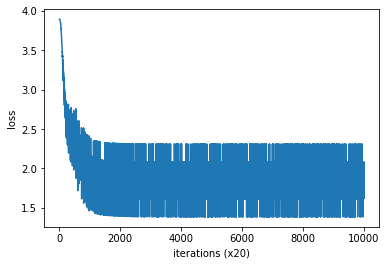

In [122]:
trainer.plot()

In [123]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id].numpy())

you [-0.00756939  0.00210646 -0.01666779 -0.00157503  0.01000431]
say [-2.3749007e-03 -3.6670646e-01  1.6798077e+00 -1.3711232e+00
  2.3978755e+00]
goodbye [-1.1289214  -2.1930299  -0.98373556  1.3899378  -1.3810318 ]
and [ 3.7749484  4.3821445  2.01873   -2.6743627  1.0426625]
i [-1.1175189  -2.1911743  -0.99374133  1.409356   -1.3581986 ]
hello [-1.6794059  2.0335512 -2.0116348  1.194223  -1.431749 ]
. [-0.00342027 -0.00981936 -0.01061032 -0.00852982 -0.00393318]
